In [2]:
import pandas as pd
import numpy as np
import stan
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

In [3]:
from cmdstanpy import CmdStanModel, set_cmdstan_path, cmdstan_path
import arviz as az
import os

/Users/indiaermacora/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import os
os.environ['CMDSTAN'] = '/Users/indiaermacora/.cmdstan/cmdstan-2.31.0'

In [5]:
cmdstan_path()

'/Users/indiaermacora/.cmdstan/cmdstan-2.31.0'

In [6]:
month=np.repeat(np.array([1,2,3,4,5,6,7,8,9,10,11,12]), [31,28,31,30,31,30,31,31,30,31,30,31])

In [7]:
nugget = pd.read_csv('stan/nugget_to_python.csv', sep = ";")
data_vec = pd.read_csv('stan/dat_complete_log_to_python.csv', sep = ';') #log PM10 values
ind_miss = pd.read_csv('stan/ind_miss_to_python.csv', sep = ';')
ind_pres = pd.read_csv('stan/ind_pres_to_python.csv', sep = ';')
dati_covariates = pd.read_csv('stan/covariates.csv', sep = ";")

In [8]:
nugget_mat = np.matrix(nugget, dtype=float)

data_vettore = np.array(data_vec, dtype=float)
ind_miss = np.array(ind_miss)
ind_pres = np.array(ind_pres)

matrix_dati_covariates=np.matrix(dati_covariates)
quota= np.array (matrix_dati_covariates[0,:], dtype=int)
quota_norm = ((quota-quota.mean())/quota.std())

area_dummies = pd.get_dummies(dati_covariates.iloc[1, :])

zona_dummies = pd.get_dummies(dati_covariates.iloc[2, :])
all_cov = np.matrix(pd.concat([area_dummies.Urbano, area_dummies.Suburbano, 
                               zona_dummies.Industriale, zona_dummies.Traffico],axis=1),dtype=bool)
all_cov = np.concatenate((np.transpose(quota_norm),all_cov),axis=1)

In [277]:
fourier_model = """

data {
  int<lower=0> num_giorni;  //number of obs
  int<lower=0> num_stazioni;  //number of stations
  //int<lower=0> d;  //length of vector of basis
  //vector[d] vec_k;  //vector of basis
  vector[num_giorni] t;  //time instant
  matrix[num_stazioni,num_stazioni] dist_w;  //distance matrix
  int Ncomp; // Number of non-missing values
  int  Nmiss; // Number of missing values
  int ind_pres[Ncomp, 2];
  int ind_miss[Nmiss, 2];
  vector[Ncomp] dat_complete;
  matrix[num_stazioni, 5] covariates;
  array[num_giorni] int mese;
  int C;
}


parameters {
  vector<lower=0>[12] sigma;
  
  real alpha; 
  vector[num_stazioni] beta;
  real alpha2;
  real beta2;
  real alpha4; 
  real beta4;
  
  real<lower=0> a;
  real<lower=0> phi;
  vector[num_stazioni] w;
  vector [Nmiss] dat_miss;
  real beta_0;
  vector[5] beta_cov;
  
  vector<lower=0>[C] s_sq;
  vector[C] m;
  vector<lower=0, upper=1>[C-1] v;
  //vector[C] m0;
}


transformed parameters {

  real param=2.0;
  
  real omega = 2*pi()/365;
  matrix[num_giorni, num_stazioni] fourier;
  matrix[num_giorni,num_stazioni] mu;
  matrix[num_stazioni,num_stazioni] cov_w;
  
  matrix [num_giorni,num_stazioni] y;


  for (i in 1:Ncomp) {
    y[ind_pres[i,1], ind_pres[i,2]] =  dat_complete[i];
  }
  for(i in 1:Nmiss) {
      y[ind_miss[i,1],ind_miss[i,2]] = dat_miss[i];
    }


  for(i in 1:num_stazioni){
      fourier[:,i] = (rep_vector(0, num_giorni));
      fourier[:,i]+= alpha*sin(omega*t)+beta[i]*cos(omega*t) + alpha2*sin(2*omega*t) + beta2*cos(2*omega*t) + alpha4*sin(4*omega*t) + beta4*cos(4*omega*t);
  }
  

  cov_w = a*exp(-phi*dist_w);
  
  for(j in 1:num_stazioni){
    mu[:,j] = beta_0 + covariates[j,:]*beta_cov + fourier[:,j] + w[j];
  }
  
  vector<lower=0>[C] s=sqrt(s_sq);

  vector<lower=0, upper=1>[C-1] cumprod_one_minus_v;
  cumprod_one_minus_v = exp(cumulative_sum(log1m(v)));

  simplex[C] eta;
  eta[1]=v[1];
  eta[2:(C-1)] = v[2:(C-1)] .* cumprod_one_minus_v[1:(C-2)];
  eta[C] = cumprod_one_minus_v[C-1];
}


model {
  sigma ~ inv_gamma(3,2);

  alpha ~ normal(0,1);
  alpha2 ~ normal(0,1);
  alpha4 ~ normal(0,1);
  
  beta2 ~ normal(0,1);
  beta4 ~ normal(0,1);

  a ~ inv_gamma(3,2);
  phi ~ beta(7,70);

  beta_0 ~ normal(0, 2);
  beta_cov ~ normal(rep_vector(0,5), 2);

  w ~ multi_normal(rep_vector(0,num_stazioni),cov_w);
  
  for (i in 1:365)
      y[i,:] ~ normal(mu[i,:], sqrt(sigma[mese[i]]));
      
  
  m[1:C] ~ normal(0 , 10*s[1:C]);
  //m0 ~ normal(0,1);
  s_sq ~ inv_gamma(3, 0.035);
  v ~ beta(1, param);

  for(i in 1:num_stazioni){
    vector[C] lps=log(eta);
    for(j in 1:C){
      lps[j] += normal_lpdf(beta[i] | m[j], s[j]);
    }
    target += log_sum_exp(lps);
  }
      
}


generated quantities {
  vector[num_giorni*num_stazioni] log_lik;
  {
    matrix [num_giorni, num_stazioni] temp; 
    for (i in 1:365) {
      for (j in 1:num_stazioni) {
      temp[i,j]= normal_lpdf(y[i,j] | mu[i,j], sqrt(sigma[mese[i]]));
      }
    }
    log_lik = to_vector(temp);
  }
  
  int cluster_allocs[num_stazioni];
  for(i in 1:num_stazioni){
    vector[C] log_probs = log(eta);
    for( j in 1:C){
      log_probs[j] += normal_lpdf(beta[i] | m[j], s[j]);
    }
    cluster_allocs[i] = categorical_rng(softmax(log_probs));
  }
  
}

"""

stan_file = "./fourier.stan"

with open(stan_file, "w") as f:
    print(fourier_model, file=f)

fourier = CmdStanModel(stan_file=stan_file)

10:31:23 - cmdstanpy - INFO - compiling stan file /Users/indiaermacora/PycharmProjects/pythonProject/fourier.stan to exe file /Users/indiaermacora/PycharmProjects/pythonProject/fourier
10:31:34 - cmdstanpy - INFO - compiled model executable: /Users/indiaermacora/PycharmProjects/pythonProject/fourier
10:31:34 - cmdstanpy - WARNING - Stan compiler has produced 3 warnings:
10:31:34 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/Users/indiaermacora/PycharmProjects/pythonProject/fourier.hpp /Users/indiaermacora/PycharmProjects/pythonProject/fourier.stan
Warning in '/Users/indiaermacora/PycharmProjects/pythonProject/fourier.stan', line 12, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/Users/indiaermacora/PycharmProjects/pythonProject/f

In [279]:
reg_data = {
    "num_giorni": 365,
    "num_stazioni": 62,
    "t": np.arange(1,366),
    "dist_w": nugget_mat,
    "Ncomp": np.shape(ind_pres)[0],
    "Nmiss": np.shape(ind_miss)[0],
    "ind_pres": ind_pres,
    "ind_miss": ind_miss,
    "dat_complete": data_vettore[:,0],
    "covariates": all_cov,
    "mese": month,
    "C": 10
}  

fit = fourier.sample(data=reg_data, chains=1, parallel_chains=1, 
                iter_warmup=1000, iter_sampling=1000)
fourier_az = az.from_cmdstanpy(fit)

10:35:41 - cmdstanpy - INFO - CmdStan start processing

chain 1 |                                                                                                                               | 00:00 Status
chain 1 |█████▊                                                                                                                         | 00:00 Status
chain 1 |████████▌                                                                                     | 05:50 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |████████████▊                                                                                 | 08:46 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█████████████████                                                                             | 10:59 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |█████████████████████▎                                                                        | 13:21 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |█████████████████████████▋   


11:22:23 - cmdstanpy - INFO - CmdStan done processing.
11:22:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Random variable is 2.38339, but must be in the interval [0, 1] (in '/Users/indiaermacora/PycharmProjects/pythonProject/fourier.stan', line 100, column 2 to column 19)
	Exception: beta_lpdf: Random variable is 1.96553, but must be in the interval [0, 1] (in '/Users/indiaermacora/PycharmProjects/pythonProject/fourier.stan', line 100, column 2 to column 19)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = inf, but Covariance matrix[2,1] = inf (in '/Users/indiaermacora/PycharmProjects/pythonProject/fourier.stan', line 105, column 2 to column 53)
Consider re-running with show_console=True if the above output is unclear!


In [280]:
#to save the model  
import pickle 
pickle.dump(fit, open('fourier_clustering_6.p', 'wb'))

array([[<AxesSubplot: title={'center': 'beta_cov'}>,
        <AxesSubplot: title={'center': 'beta_cov'}>],
       [<AxesSubplot: title={'center': 'beta_0'}>,
        <AxesSubplot: title={'center': 'beta_0'}>],
       [<AxesSubplot: title={'center': 'sigma'}>,
        <AxesSubplot: title={'center': 'sigma'}>],
       [<AxesSubplot: title={'center': 'a'}>,
        <AxesSubplot: title={'center': 'a'}>],
       [<AxesSubplot: title={'center': 'phi'}>,
        <AxesSubplot: title={'center': 'phi'}>],
       [<AxesSubplot: title={'center': 'w'}>,
        <AxesSubplot: title={'center': 'w'}>]], dtype=object)

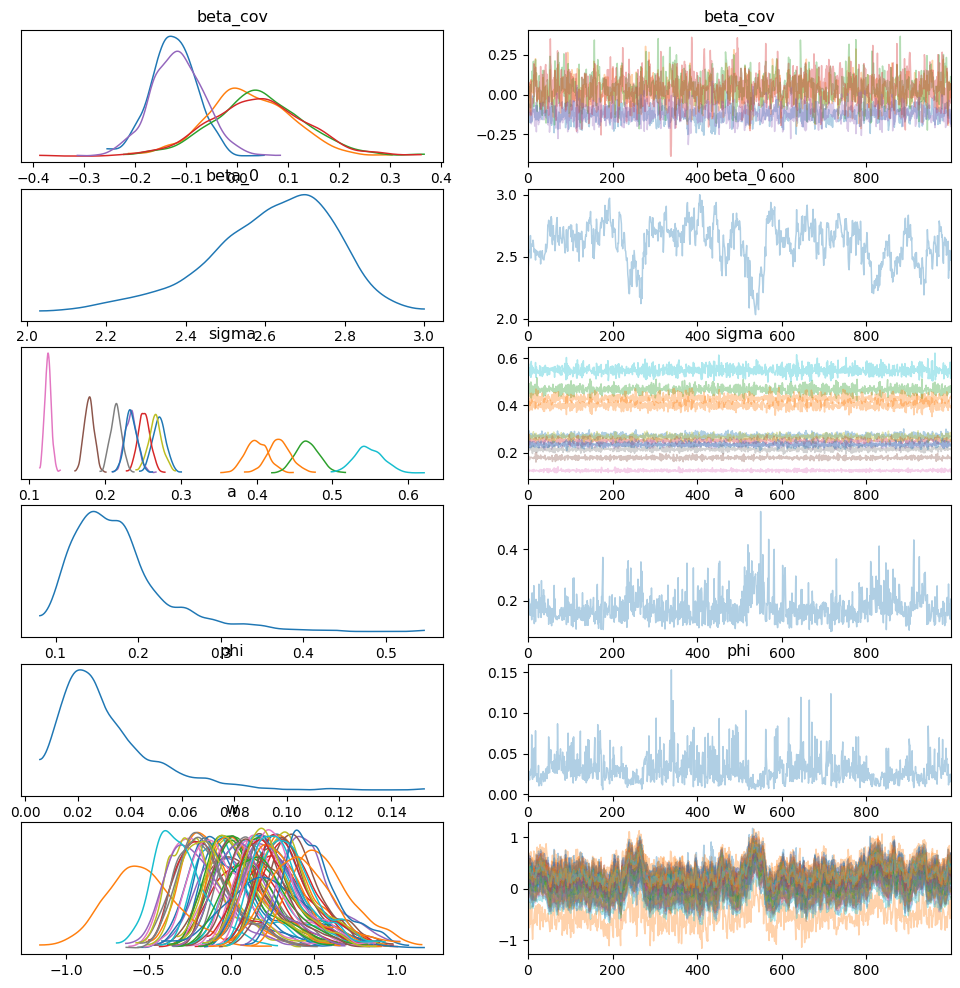

In [281]:
az.plot_trace(fourier_az, var_names=['beta_cov','beta_0','sigma','a','phi','w'])

array([[<AxesSubplot: title={'center': 'alpha'}>,
        <AxesSubplot: title={'center': 'alpha'}>],
       [<AxesSubplot: title={'center': 'beta'}>,
        <AxesSubplot: title={'center': 'beta'}>],
       [<AxesSubplot: title={'center': 'alpha2'}>,
        <AxesSubplot: title={'center': 'alpha2'}>],
       [<AxesSubplot: title={'center': 'beta2'}>,
        <AxesSubplot: title={'center': 'beta2'}>],
       [<AxesSubplot: title={'center': 'alpha4'}>,
        <AxesSubplot: title={'center': 'alpha4'}>],
       [<AxesSubplot: title={'center': 'beta4'}>,
        <AxesSubplot: title={'center': 'beta4'}>]], dtype=object)

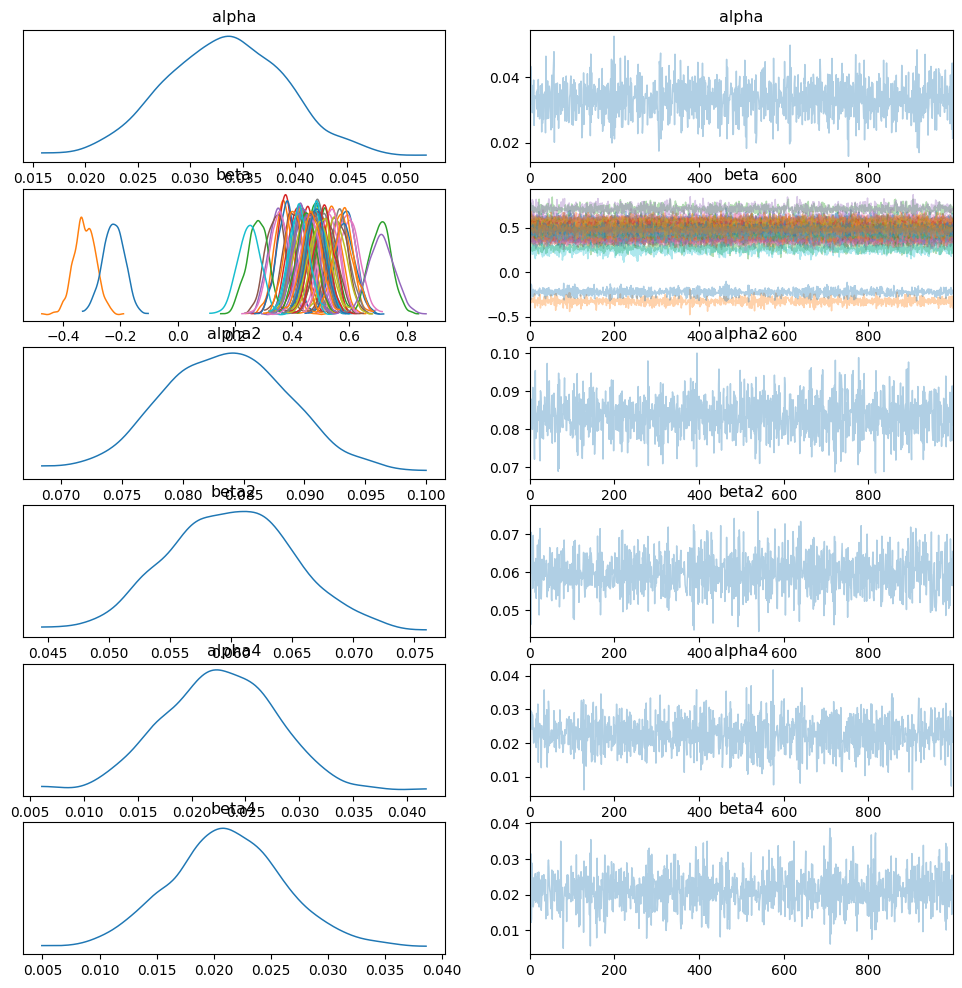

In [282]:
az.plot_trace(fourier_az, var_names=['alpha','beta', 'alpha2', 'beta2', 'alpha4', 'beta4'])

array([[<AxesSubplot: title={'center': 'sigma'}>,
        <AxesSubplot: title={'center': 'sigma'}>]], dtype=object)

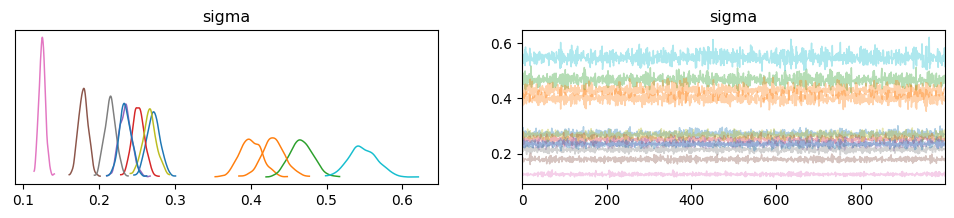

In [283]:
az.plot_trace(fourier_az, var_names=['sigma'])

In [284]:
np.sum(fourier_az.sample_stats.diverging)

<xarray.DataArray 'diverging' ()>
array(0)

In [285]:
clustering = fit.stan_variable(var="cluster_allocs")

In [286]:
np.shape(clustering)

(1000, 62)

In [287]:
clustering[1,:] #first iter, all stations

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1.,
       1., 1., 1., 1., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 8., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 8., 1., 1., 1., 1., 1., 5.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Text(0.5, 1.0, 'Non-null clusters for each iteration')

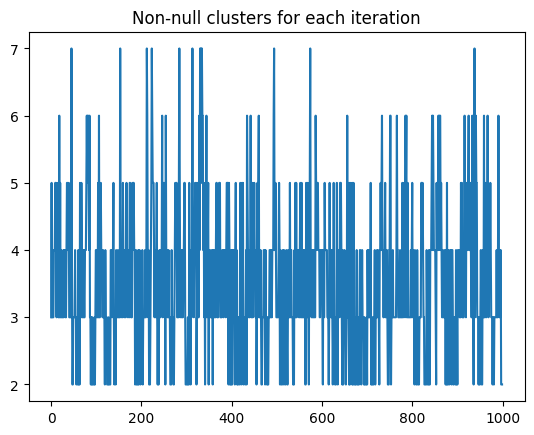

In [288]:
num_cluster_iter = np.zeros(clustering.shape[0])
for i in range(clustering.shape[0]):
    num_cluster_iter[i] = (np.unique(clustering[i,:])).shape[0]
     
plt.plot(num_cluster_iter)
plt.title('Non-null clusters for each iteration')

Text(0.5, 1.0, 'Histogram of non-null clusters for each iteration')

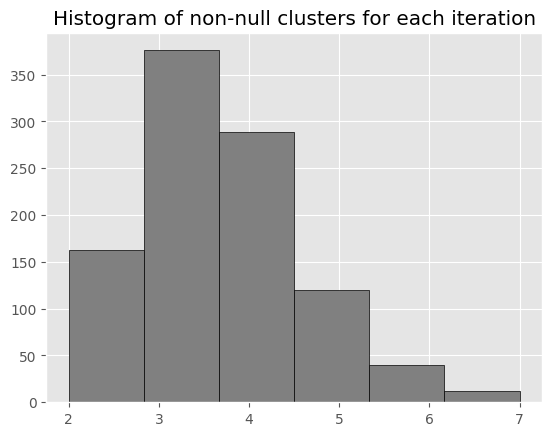

In [323]:
plt.hist(num_cluster_iter, bins = 6, facecolor = 'grey', edgecolor = 'black')
plt.title('Histogram of non-null clusters for each iteration')

In [310]:
help(plt.hist)

Help on function hist in module matplotlib.pyplot:

hist(x, bins=None, range=None, density=False, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, *, data=None, **kwargs)
    Compute and plot a histogram.
    
    This method uses `numpy.histogram` to bin the data in *x* and count the
    number of values in each bin, then draws the distribution either as a
    `.BarContainer` or `.Polygon`. The *bins*, *range*, *density*, and
    *weights* parameters are forwarded to `numpy.histogram`.
    
    If the data has already been binned and counted, use `~.bar` or
    `~.stairs` to plot the distribution::
    
        counts, bins = np.histogram(x)
        plt.stairs(counts, bins)
    
    Alternatively, plot pre-computed bins and counts using ``hist()`` by
    treating each bin as a single point with a weight equal to its count::
    
        plt.hist(bins[:-1], bins, weights=coun

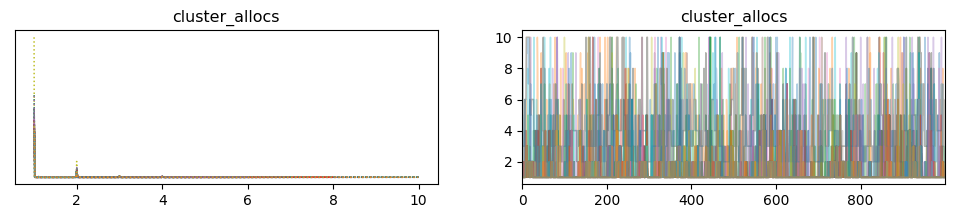

In [289]:
az.plot_trace(fourier_az, var_names=["cluster_allocs"], combined= True)
plt.show()

In [290]:
def pi_i_j(clustering):
    #returns P(ci==cj | data)
    pi = np.zeros((clustering.shape[1], clustering.shape[1])) #matrix of dimension (num_staz, num_staz)
    for i in range(clustering.shape[1]):
        for j in range(clustering.shape[1]):
            pi[i, j] = np.mean(clustering[:, i] == clustering[:, j])
    return pi


def binder_loss(clustering, pi_i_j):
    loss = np.zeros(len(clustering)) #for each iter I compute the binder's loss a posteriori 
    for i in range(clustering.shape[1]):
        for j in range(i):
            loss += (np.mean(clustering[:, i] == clustering[:, j]) - pi_i_j[i, j])**2
    #I choose as best iteration the one which minimizes the loss
    best_iter = np.argmin(loss)
    return clustering[best_iter]

In [291]:
pi = pi_i_j(clustering)

In [292]:
best_clus = binder_loss(clustering, pi)
best_clus

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 5.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [293]:
best_clus_int = np.asarray(best_clus, dtype = 'int')
best_clus_int

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [294]:
possible_clusters = np.unique (best_clus_int)
possible_clusters
possible_clusters.shape[0] #sum of clusters

3

In [295]:
import os
df = pd.DataFrame(best_clus)
df.to_csv('stan/cluster_fourier.csv')

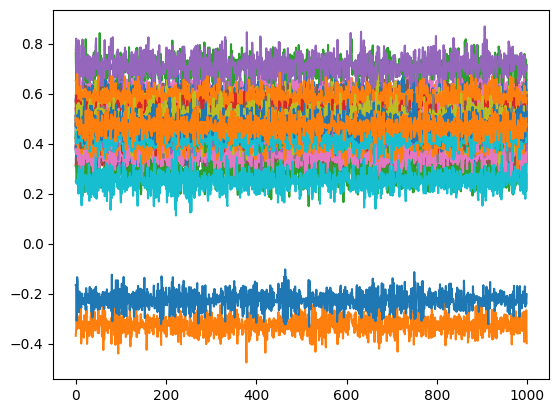

In [296]:
phi2_cluster_chain = fit.stan_variable(var="beta")
plt.plot(phi2_cluster_chain)
Q1 = np.zeros(62)
Q2 = np.zeros(62)
Q3 = np.zeros(62)
phi2_cluster = []
for i in range(62):
    Q1[i]= np.quantile(phi2_cluster_chain[:,i], 0.025)
    Q2[i]= np.quantile(phi2_cluster_chain[:,i], 0.5)
    Q3[i]= np.quantile(phi2_cluster_chain[:,i], 0.975)
    phi2_cluster.append((phi2_cluster_chain[:,i]).tolist())

#print(Q2)
#print(Q1, Q3)

In [297]:
np.shape(phi2_cluster)

(62, 1000)

In [298]:
import matplotlib.pyplot as plt
import statistics
from math import sqrt


def plot_confidence_interval(x, values, cluster, possible_clusters, horizontal_line_width=0.25):
    median = np.quantile(values, 0.5)
    if cluster == possible_clusters[0]:
        color ='r'
    elif cluster ==possible_clusters[1]:
        color ='b'
    elif cluster ==possible_clusters[2]:
        color ='g'
    elif cluster ==possible_clusters[3]:
        color ='k'
    elif cluster ==possible_clusters[4]:
        color ='c'
    else:
        color = 'y'
    left = x - horizontal_line_width / 2
    bottom = np.quantile(values, 0.025)
    right = x + horizontal_line_width / 2
    top = np.quantile(values, 0.975)
    
    confidence_interval = [bottom, top]
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, median, 'o', color = color)

    return median, confidence_interval


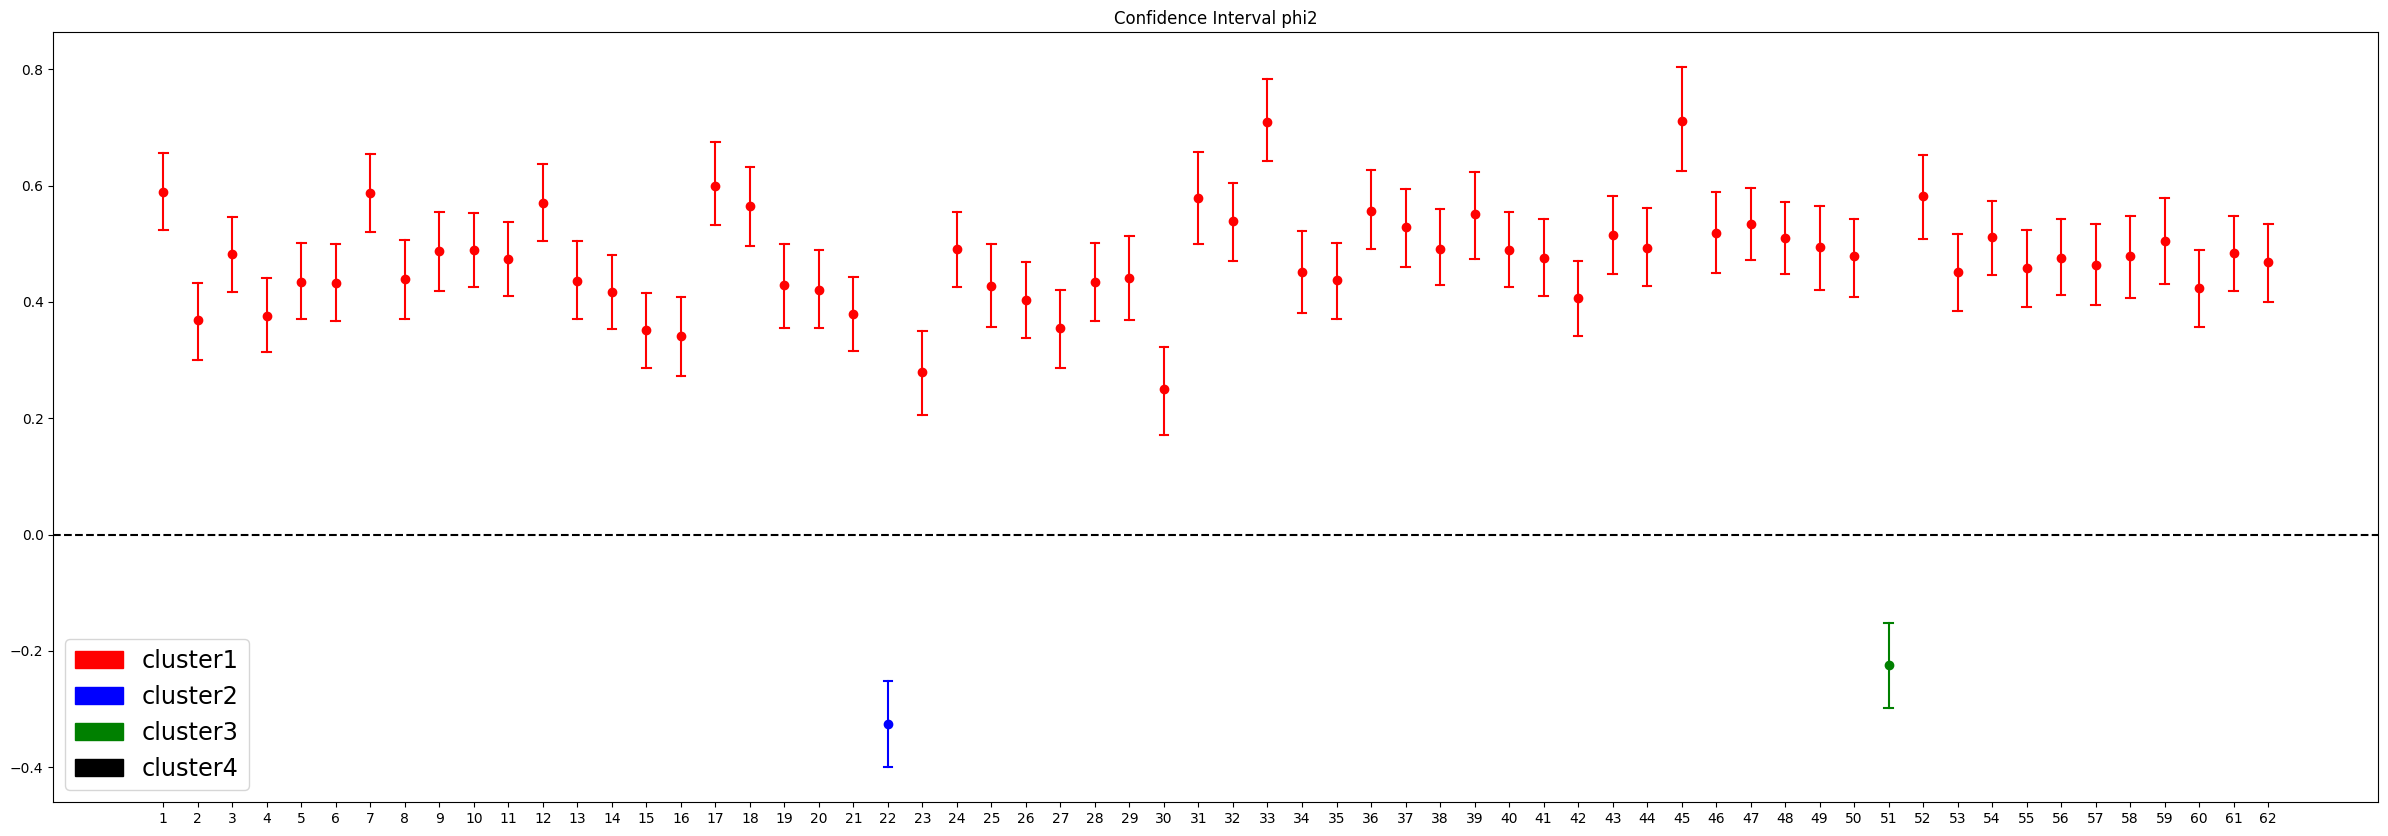

In [300]:
import matplotlib.patches as mpatches
plt.figure(figsize=(30, 10))
plt.xticks(np.arange(62)+1)
plt.title('Confidence Interval phi2')
plt.axhline(y=0, color= 'black', linestyle = '--')
for i in range(62):
 plot_confidence_interval(i+1, phi2_cluster[i][:], best_clus_int[i], possible_clusters)
red_patch = mpatches.Patch(color='red', label='cluster1')
blue_patch = mpatches.Patch(color='blue', label='cluster2')
green_patch = mpatches.Patch(color='green', label='cluster3')
black_patch = mpatches.Patch(color='black', label='cluster4')
plt.legend(handles=[red_patch, blue_patch, green_patch, black_patch], loc = 'lower left', fontsize = 'xx-large')
plt.show()

In [9]:
data_log = pd.read_csv('stan/data_log.csv', sep = ";")

In [18]:
data_log_matrix = np.matrix(data_log, dtype=float)

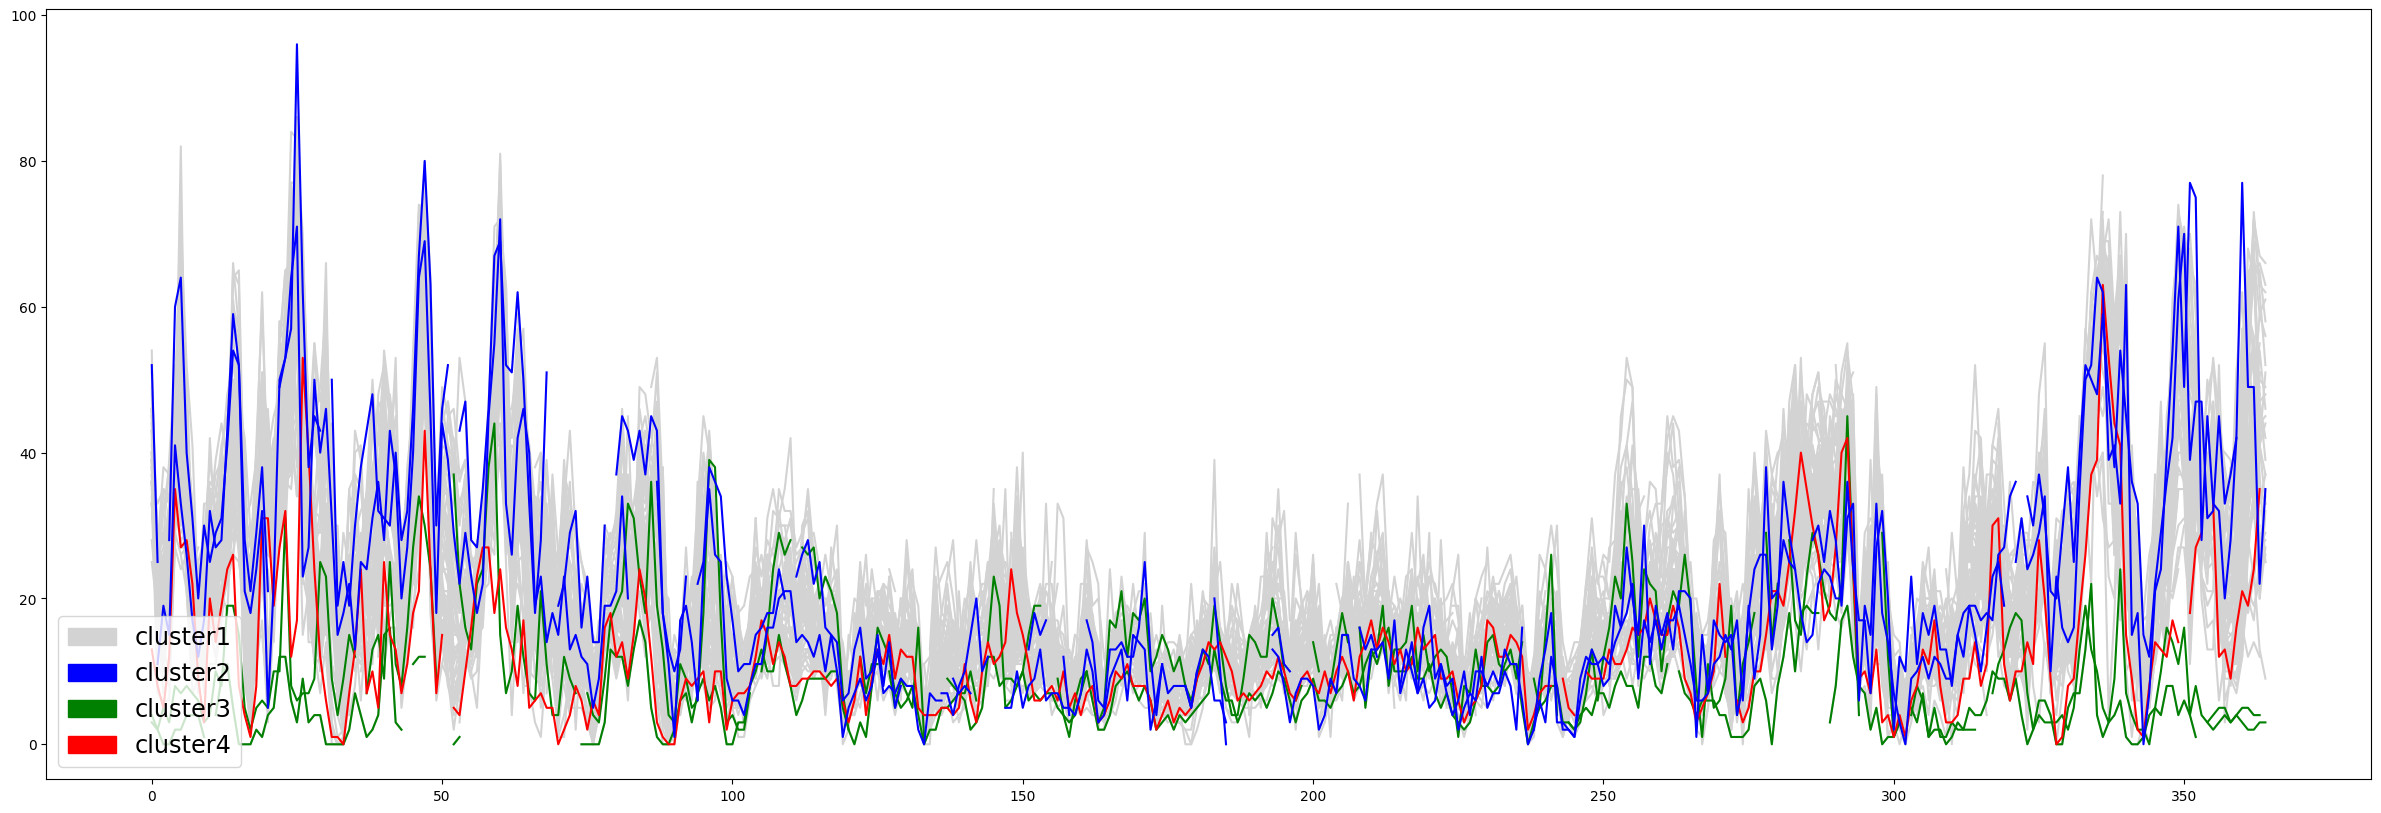

In [97]:
import matplotlib.patches as mpatches
np.shape(data_log_matrix)
plt.figure(figsize=(30, 10))
for j in range(62):
    i = j+1
    if (i != 30 and 1!= 22 and i!=51 and i!=33 and i!=45):
        plt.plot(np.exp(data_log_matrix[:,j]), color = 'lightgrey')
        
grey_patch = mpatches.Patch(color='lightgrey', label='cluster1')
blue_patch = mpatches.Patch(color='blue', label='cluster2')
green_patch = mpatches.Patch(color='green', label='cluster3')
black_patch = mpatches.Patch(color='red', label='cluster4')
plt.plot(np.exp(data_log_matrix[:,22-1]), color = 'g') #Rurale, Fondo
plt.plot(np.exp(data_log_matrix[:,51-1]), color = 'g') #Rurale, Fondo
plt.plot(np.exp(data_log_matrix[:,30-1]), color = 'r') #Rurale, Fondo
plt.plot(np.exp(data_log_matrix[:,33-1]), color = 'b') #Urbano, Fondo
plt.plot(np.exp(data_log_matrix[:,45-1]), color = 'b') #Suburbano, Fondo
plt.legend(handles=[grey_patch, blue_patch, green_patch, black_patch], loc = 'lower left', fontsize = 'xx-large')
plt.show()

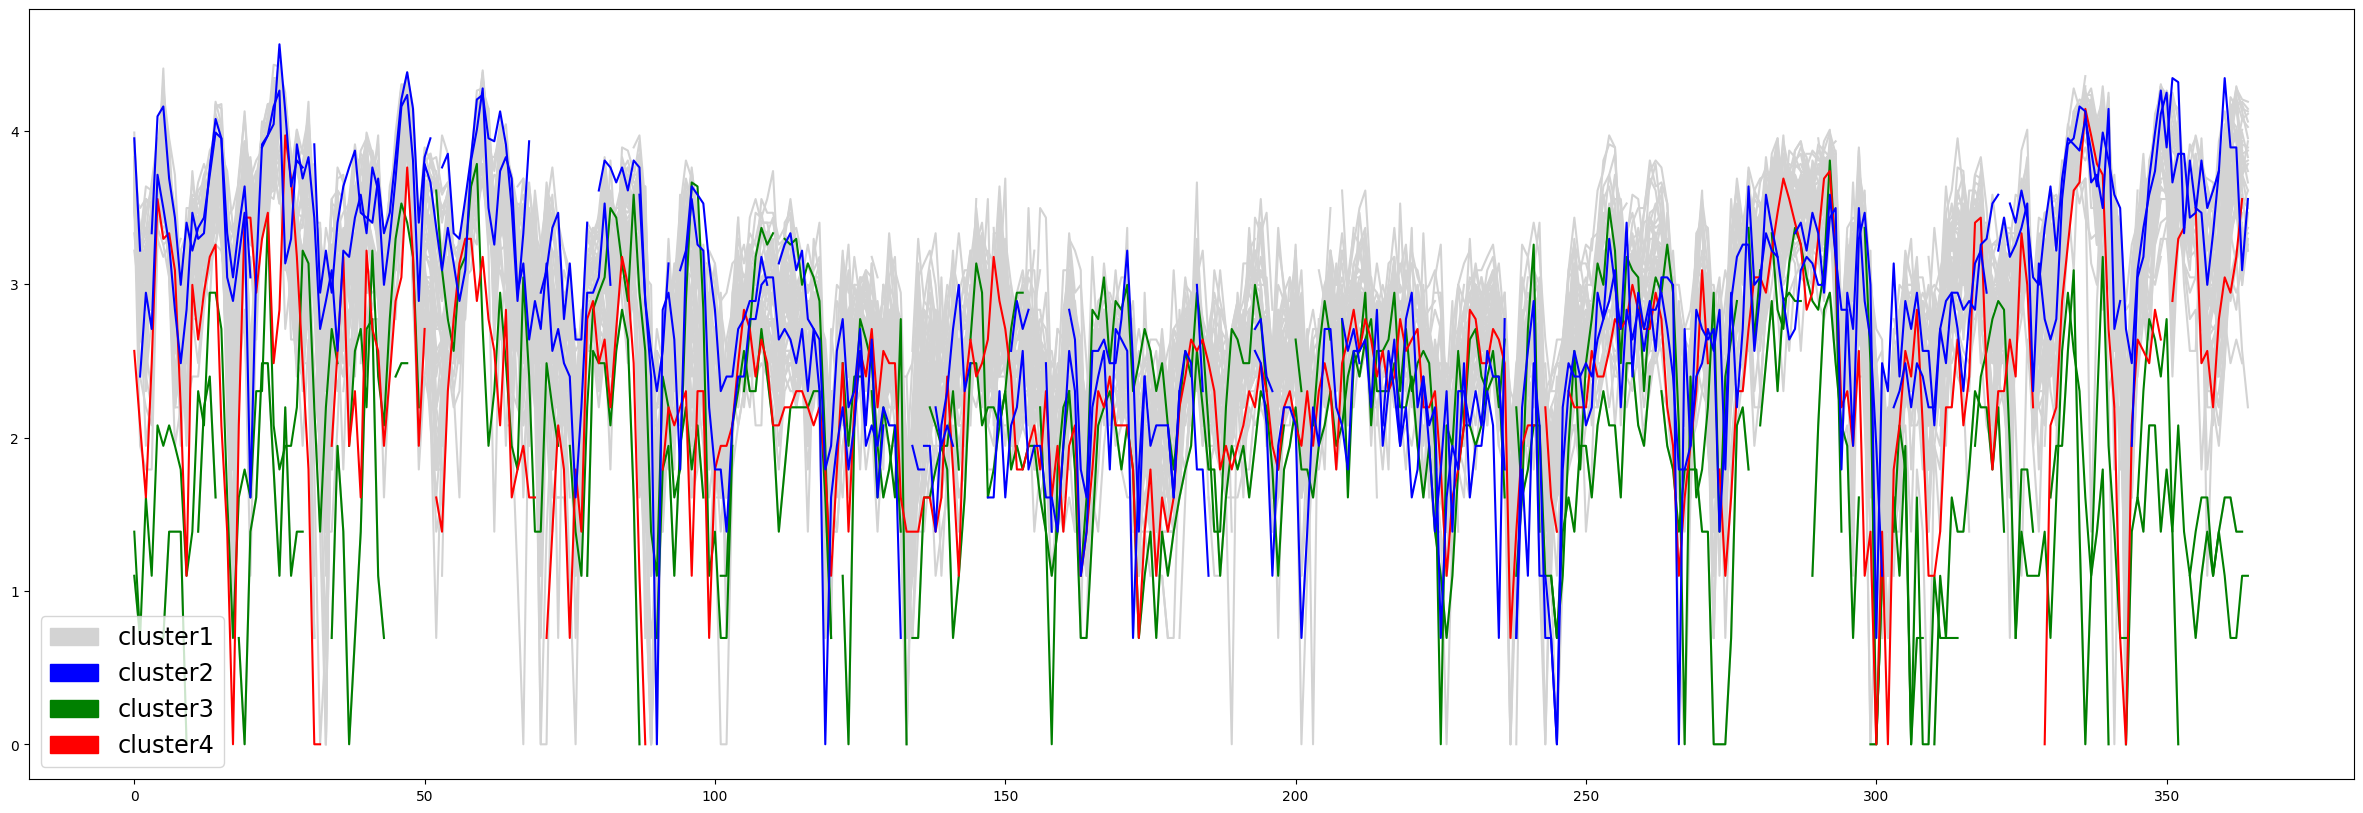

In [98]:
import matplotlib.patches as mpatches
np.shape(data_log_matrix)
plt.figure(figsize=(30, 10))
for j in range(62):
    i = j+1
    if (i != 30 and 1!= 22 and i!=51 and i!=33 and i!=45):
        plt.plot(data_log_matrix[:,j], color = 'lightgrey')
        
grey_patch = mpatches.Patch(color='lightgrey', label='cluster1')
blue_patch = mpatches.Patch(color='blue', label='cluster2')
green_patch = mpatches.Patch(color='green', label='cluster3')
black_patch = mpatches.Patch(color='red', label='cluster4')
plt.plot(data_log_matrix[:,22-1], color = 'g') #Rurale, Fondo
plt.plot(data_log_matrix[:,51-1], color = 'g') #Rurale, Fondo
plt.plot(data_log_matrix[:,30-1], color = 'r') #Rurale, Fondo
plt.plot(data_log_matrix[:,33-1], color = 'b') #Urbano, Fondo
plt.plot(data_log_matrix[:,45-1], color = 'b') #Suburbano, Fondo
plt.legend(handles=[grey_patch, blue_patch, green_patch, black_patch], loc = 'lower left', fontsize = 'xx-large')
plt.show()

In [45]:
np.shape(matrix_dati_covariates)

(3, 62)

In [66]:
matrix_dati_covariates[2,44]

'Fondo'

In [91]:
#how many fondo: 43
np.sum(zona_dummies['Fondo'])

43

In [93]:
#how many rurale: 16
np.sum(area_dummies['Rurale'])

16

In [94]:
#how many rurale: 16
np.sum(area_dummies['Urbano'])

34